In [1]:
from Data.IMDB import IMDB
from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
import dgl
import torch    

/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /storage/scratch/0994359/hetero-conv-matching/.venv2/lib/python3.9/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/

In [17]:
imdb = IMDB()
original_graph = imdb.load_graph(n_components=20)
device = "cuda:2"
original_graph = original_graph.to(device)

In [18]:
from Projections.MultiViewAutoEncoder import MultiViewAutoencoder
dim_actor = original_graph.nodes["actor"].data["feat_pca"].shape[1] #* original_graph.nodes["actor"].data["feat_pca"].shape[0]
dim_movie = original_graph.nodes["movie"].data["feat_pca"].shape[1] #* original_graph.nodes["movie"].data["feat_pca"].shape[0]
dim_director = original_graph.nodes["director"].data["feat_pca"].shape[1]# * original_graph.nodes["director"].data["feat_pca"].shape[0]

model = MultiViewAutoencoder([dim_actor, dim_movie, dim_director], latent_dim=100 ,device=device)
#learner.fit(original_graph.nodes["actor"].data["feat_pca"], original_graph.nodes["movie"].data["feat_pca"], original_graph.nodes["director"].data["feat_pca"])


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Dataset class for a single view
class SingleViewDataset(Dataset):
    def __init__(self, data):
        # data: tensor of shape (num_samples, d1, d2)
        self.data = data

    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]  # already 1D

class MultiViewDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets
        self.length = min(len(d) for d in datasets)  # shortest length to avoid indexing errors

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return tuple(d[idx] for d in self.datasets)
multi_view_dataset = MultiViewDataset([original_graph.nodes["actor"].data["feat_pca"], original_graph.nodes["movie"].data["feat_pca"], original_graph.nodes["director"].data["feat_pca"]])
multi_view_loader = DataLoader(multi_view_dataset, batch_size=32, shuffle=True)


# Prepare datasets and dataloaders
actor_dataset = SingleViewDataset(original_graph.nodes["actor"].data["feat_pca"])
movie_dataset = SingleViewDataset(original_graph.nodes["movie"].data["feat_pca"])
director_dataset = SingleViewDataset(original_graph.nodes["director"].data["feat_pca"])

batch_size = 32

actor_loader = DataLoader(actor_dataset, batch_size=batch_size, shuffle=True)
movie_loader = DataLoader(movie_dataset, batch_size=batch_size, shuffle=True)
director_loader = DataLoader(director_dataset, batch_size=batch_size, shuffle=True)


# Initialize model
model = MultiViewAutoencoder(
    [dim_actor, dim_movie, dim_director], latent_dim=100, device=device
)
model.train()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    # Create iterators for each loader
    actor_iter = iter(actor_loader)
    movie_iter = iter(movie_loader)
    director_iter = iter(director_loader)

    num_batches = min(len(actor_loader), len(movie_loader), len(director_loader))
    for actor_batch, movie_batch, director_batch in multi_view_loader:
        actor_batch = actor_batch.to(device)
        movie_batch = movie_batch.to(device)
        director_batch = director_batch.to(device)

        reconstructions = model(actor_batch, movie_batch, director_batch)
    # for _ in range(num_batches):
    #     try:
    #         actor_batch = next(actor_iter).to(device)
    #     except StopIteration:
    #         actor_iter = iter(actor_loader)
    #         actor_batch = next(actor_iter).to(device)

    #     try:
    #         movie_batch = next(movie_iter).to(device)
    #     except StopIteration:
    #         movie_iter = iter(movie_loader)
    #         movie_batch = next(movie_iter).to(device)

    #     try:
    #         director_batch = next(director_iter).to(device)
    #     except StopIteration:
    #         director_iter = iter(director_loader)
    #         director_batch = next(director_iter).to(device)

    #     optimizer.zero_grad()
    #     print(actor_batch.shape)  # (batch_size, dim_actor)
    #     print(movie_batch.shape)  # (batch_size, dim_movie)
    #     print(director_batch.shape)  # (batch_size, dim_director)
    #     reconstructions = model(actor_batch, movie_batch, director_batch)

        # Sum reconstruction losses for each view
        loss = 0
        for x_real, x_recon in zip([actor_batch, movie_batch, director_batch], reconstructions):
            loss += criterion(x_recon, x_real)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")


Epoch 1/100, Loss: 0.323289
Epoch 2/100, Loss: 0.123648
Epoch 3/100, Loss: 0.089042
Epoch 4/100, Loss: 0.132882
Epoch 5/100, Loss: 0.075571
Epoch 6/100, Loss: 0.042877
Epoch 7/100, Loss: 0.064262
Epoch 8/100, Loss: 0.045762
Epoch 9/100, Loss: 0.041579
Epoch 10/100, Loss: 0.037303
Epoch 11/100, Loss: 0.014847
Epoch 12/100, Loss: 0.025241
Epoch 13/100, Loss: 0.022701
Epoch 14/100, Loss: 0.016024
Epoch 15/100, Loss: 0.026341
Epoch 16/100, Loss: 0.021531
Epoch 17/100, Loss: 0.017400
Epoch 18/100, Loss: 0.023286
Epoch 19/100, Loss: 0.018769
Epoch 20/100, Loss: 0.026240
Epoch 21/100, Loss: 0.020444
Epoch 22/100, Loss: 0.018157
Epoch 23/100, Loss: 0.029311
Epoch 24/100, Loss: 0.022468
Epoch 25/100, Loss: 0.014890
Epoch 26/100, Loss: 0.028144
Epoch 27/100, Loss: 0.024488
Epoch 28/100, Loss: 0.016115
Epoch 29/100, Loss: 0.024113
Epoch 30/100, Loss: 0.026383
Epoch 31/100, Loss: 0.024131
Epoch 32/100, Loss: 0.017735
Epoch 33/100, Loss: 0.022424
Epoch 34/100, Loss: 0.025778
Epoch 35/100, Loss: 0.0

In [20]:
model.eval()
with torch.no_grad():
    # Suppose actor_features, movie_features, director_features are your full datasets (torch tensors)
    latent_representations = model.encode(original_graph.nodes["actor"].data["feat_pca"], original_graph.nodes["movie"].data["feat_pca"], original_graph.nodes["director"].data["feat_pca"])


In [21]:
latent_representations[0].shape
latent_representations[1].shape
original_graph.nodes["actor"].data["feat_pca"] = latent_representations[0]
original_graph.nodes["movie"].data["feat_pca"] = latent_representations[1]
original_graph.nodes["director"].data["feat_pca"] = latent_representations[2]

In [22]:

num_nearest_init_neighbors_per_type = {"actortomovie": 50, "directortomovie": 50, "movietoactor":50, "movietodirector":50, "actor":50, "director":50, "movie":50}
from Projections.ContrastiveLearner import ContrastiveLearner
from Projections.JLRandom import JLRandomProjection
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type,  checkpoints=[0.9, 0.5, 0.3] ,folder_name="imdb_auto_full",device=device, use_zscore=False, pairs_per_level=20,norm_p=1, approx_neigh=True, add_feat=True, use_out_degree=False) 

coarsener.init()

coarsener.summarize()

/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


actortomovie
directortomovie
movietoactor
movietodirector
step: 0, ratio: 1.0
step: 1, ratio: 0.9990530303030303
step: 2, ratio: 0.9981060606060606
step: 3, ratio: 0.9971590909090909
step: 4, ratio: 0.9962121212121212
step: 5, ratio: 0.9952651515151515
step: 6, ratio: 0.9943181818181818
step: 7, ratio: 0.9933712121212122
step: 8, ratio: 0.9924242424242424
step: 9, ratio: 0.9914772727272727
step: 10, ratio: 0.990530303030303
step: 11, ratio: 0.9895833333333334
step: 12, ratio: 0.9886363636363636
step: 13, ratio: 0.9876893939393939
step: 14, ratio: 0.9867424242424242
step: 15, ratio: 0.9857954545454546
step: 16, ratio: 0.9848484848484849
step: 17, ratio: 0.9839015151515151
step: 18, ratio: 0.9829545454545454
step: 19, ratio: 0.9820075757575758
step: 20, ratio: 0.9810606060606061
step: 21, ratio: 0.9801136363636364
step: 22, ratio: 0.9791666666666666
step: 23, ratio: 0.978219696969697
step: 24, ratio: 0.9772727272727273
step: 25, ratio: 0.9763257575757576
step: 26, ratio: 0.97537878787878

In [61]:

import pickle
with open(f'results/imdb_cl_pca_30/0.3', 'rb') as fh:
        
    coarsener_imdb = pickle.load(fh) 

In [37]:

import pickle
with open(f'results/dblp_cca_pca_30/0.3', 'rb') as fh:
        
    coarsener_dblp = pickle.load(fh) 

In [40]:
coarsener_imdb.cca_cls

Projections.CCA.CCA

In [39]:
coarsener_dblp.feat_in_gcn

False

In [23]:
import torch
coarsend_graph = coarsener.summarized_graph
coarsend_graph = coarsend_graph.to(device)
#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("movie")
coarsener.make_mask(mapping, "movie")

labels = coarsener.get_labels(mapping, "movie")
coarsend_graph.nodes["movie"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.2997589531680441


In [27]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSGC import HeteroSGC
import importlib
from Models.HeteroSage import HeteroSAGE

from Models.HeteroSGC import HeteroSGCPaper
from Experiments.model_helper import run_experiments
from Experiments.plots import plot_bar, plot_line
orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,   ImprovedGCN, num_runs=1,
                                                  model_param={"hidden_dim": 64,"num_layers":4,} ,
                        optimizer_param={"lr": 0.001, "weight_decay": 5e-4}, epochs=200,eval_interval=1, target_node_type="movie", device="cuda:2")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]


In [28]:
max(orig[0]), max(coar[0])

(0.6175, 0.4925)

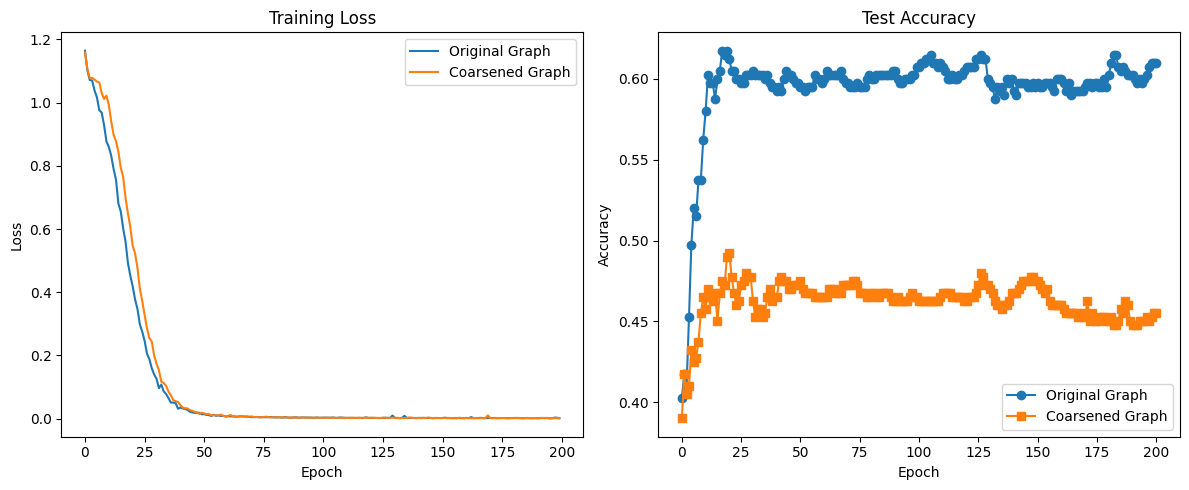

Final Performance Comparison:
Original Graph Accuracy: 0.6100
Coarsened Graph Accuracy: 0.4550

Original Graph Accuracy:
  Mean: 0.6100
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.4550
  Std:  0.0000


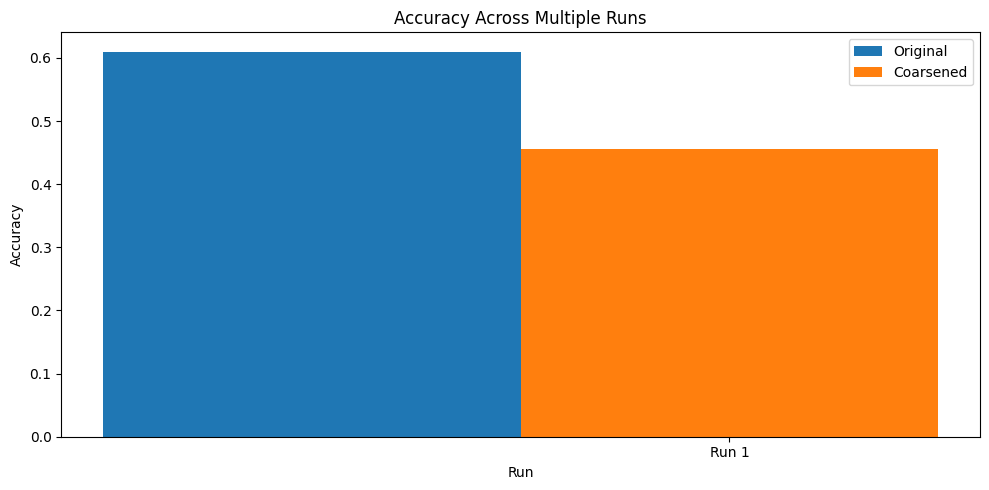

In [29]:
from Experiments.plots import plot_bar, plot_line

epochs = list(range(200))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)

TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

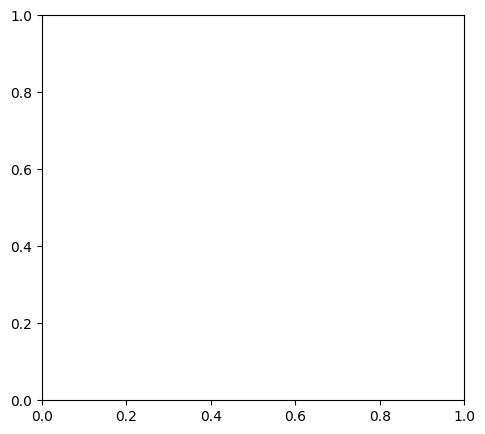

In [ ]:
epochs = torch.tensor(epochs, device=device)
